# Step 0: Enable GPU in Runtime Settings

1. Click on the menu: `Runtime` → `Change runtime type`.

2. Under `Hardware accelerator`, select: `GPU` (for NVIDIA GPUs like T4, P100, A100 depending on your Colab plan)

3. Click “Save”.

Now, your notebook will run with GPU acceleration.

Next, let's verify GPU availability

In [ ]:
import torch
# If it returns True, GPU is active.
torch.cuda.is_available()

True

In [ ]:
# Use this command to see which GPU you have
# You will see the GPU version and the total availabel memory
!nvidia-smi

Fri Dec  5 03:29:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Milestone 1: Set up the Dataset and Implement Search Tools

We will begin with a small corpus of a dataset as an example, and show how we can build a search method that finds the most related document given an input query. We will use this corpus as the database and the method as the action space for building a GPT-based agent.  


In [ ]:
# First, let's import necessary packages
from __future__ import annotations
from dataclasses import dataclass, field, asdict
from typing import Callable, Dict, List, Tuple, Optional, Any
import json, math, re, textwrap, random, os, sys
import pandas as pd
import numpy as np
from google.colab import files

In [ ]:
# Load the data
agent_df = pd.read_csv("/content/balanced_ai_human_prompts.csv")

# Inspect the data
print("\nShape of the data:")
print(agent_df.shape)
display(agent_df.head())


Shape of the data:
(2750, 2)


,text,generated
0,"Machine learning, a subset of artificial intel...",1
1,"A decision tree, a prominent machine learning ...",1
2,"Education, a cornerstone of societal progress,...",1
3,"Computers, the backbone of modern technology, ...",1
4,"Chess, a timeless game of strategy and intelle...",1


Then, we design a simple search method based on **TF-IDF** to retrieve information from the corpus.

TF-IDF (Term Frequency–Inverse Document Frequency) is a method to find the most relevant passages for a query.
1. We will split each document and the query into words.
2. We will compute TF (Term Frequency) to measure how often a word appears in a document. More frequent indicates more important within that document.
3. We will compute IDF (Inverse Document Frequency), which is used to downweight words that are common across many documents, like “the” or “and,” and upweight rarer words.
4. We will compute TF-IDF vectors (containing the TF-IDF score for each word) for both documents and the query, then compute cosine similarity between the query vector and each document vector.
5. We will compute cosine similarity between the query vector and each document vector.
6. We will implement a search method that finds the documents with the highest similarity scores as the top-k search results.

We note that this action space can mostly only retrieve a small part of a passage based on the exact passage name, which is weaker than state-of-the-art retrievers. The purpose is to simulate how the search method in Wikipedia and make models to retrieve via reasoning in language.

As an extension of the project, you can redefine the search method in this code snippet to incorporate a more powerful search method.


In [ ]:
import re
import math
from collections import Counter, defaultdict

# 1.  Tokenize the document into words
def tokenize(text: str) -> List[str]:
    return re.findall(r"[a-zA-Z0-9']+", text.lower())

# Build the CORPUS — each row of the dataset is a "document"
# Here, each document contains the text (prompt) and label (AI/Human)
CORPUS = []
for i, row in agent_df.iterrows():
    CORPUS.append({
        "id": i,
        "label": row["generated"],             # 0 or 1
        "text": row["text"]                # the actual written text
    })

# Get all the tokens for each document in the corpus
DOC_TOKENS = [tokenize(d["text"]) for d in CORPUS]

# Get all unique words from the corpus
VOCAB = sorted(set(t for doc in DOC_TOKENS for t in doc))

In [ ]:
# 2.  Compute term frequency (TF) for each doc
def compute_tf(tokens: List[str]) -> Dict[str, float]:
    # Input: A list of all the words in a document
    # Output: A dictionary of the frequency of each word

    # implement the function to compute normalized term frequency: count of word / doc length
    counts = defaultdict(int)
    for token in tokens:
      counts[token] += 1
    length = max(1, len(tokens))
    return {token: counts[token] / length for token in counts}

# 3. Compute document frequency (DF): how many documents contain a word?
def compute_df(doc_tokens: List[List[str]]) -> Dict[str, float]:
    # Input: list of lists of tokens for all docs
    # Output: dictionary of how many docs each token appears in
    df = defaultdict(int)
    for tokens in doc_tokens:
        for token in set(tokens):
            df[token] += 1
    return df

#     Compute the inverse document frequency (higher for rarer terms), in which we use a smoothed variant
DF = compute_df(DOC_TOKENS) # Get the DF
N_DOC = len(DOC_TOKENS) # number of docs
IDF = {t: math.log((N_DOC + 1) / (DF[t] + 0.5)) + 1 for t in VOCAB} # Inverse document frequency

# 4.   We compute TF-IDF vectors for each document, which is the product between
def tfidf_vector(tokens: List[str]) -> Dict[str, float]:
    # Input: A list of words in a document
    # Output: A dictionary of tf-idf score of each word
    tf = compute_tf(tokens)
    vec = {t: tf[t] * IDF.get(t, 0.0) for t in tf}
    return vec

DOC_VECS = [tfidf_vector(tokens) for tokens in DOC_TOKENS]


# 5.   We compute the cosine similarity for the search
def cosine(a: Dict[str, float], b: Dict[str, float]) -> float:
    # Inputs: Two dictrionaries of tf-idf vectors of two document
    # Output: The cosine similarity scalar between the two vector

    if not a or not b:
        return 0.0

    # Compute the cosine similarity between two tf-idf vectors
    # Notice that they are two dictionaries and could have missing keys
    # dot product
    dot = sum(a.get(k, 0.0) * b.get(k, 0.0) for k in set(a) | set(b))
    # norms
    na = math.sqrt(sum(v*v for v in a.values()))
    nb = math.sqrt(sum(v*v for v in b.values()))
    return dot / (na * nb + 1e-12)


# 6.   We implement a search method based on the cosine similarity,
#      which finds the documents with the highest similarity scores as the top-k search results.
def search_corpus(query: str, k: int = 3) -> List[Dict[str, Any]]:
    qvec = tfidf_vector(tokenize(query))
    scored = [(cosine(qvec, v), i) for i, v in enumerate(DOC_VECS)]
    scored.sort(reverse=True)
    results = []
    for score, idx in scored[:k]:
        d = CORPUS[idx].copy()
        d["score"] = float(score)
        results.append(d)
    return results

#       Integrate the search method as a tool
def tool_search(query: str, k: int = 3) -> Dict[str, Any]:
    hits = search_corpus(query, k=k)
    return {
        "tool": "search",
        "query": query,
        "results": [
            {
                "id": h["id"],
                "label": h["label"],
                "snippet": h["text"][:240] + ("..." if len(h["text"]) > 240 else ""),
                "similarity": round(h["score"], 4),
            }
            for h in hits
        ],
    }


# Tool dictionary
TOOLS = {
    "search": {
        "schema": {"query": "str", "k": "int? (default=3)"},
        "fn": tool_search,
    },
    "finish": {
        "schema": {"answer": "str"},
        "fn": lambda answer: {"tool": "finish", "answer": answer},
    },
}



In [ ]:
# Now, let's look at the scores for the words
import pandas as pd

# Show a few common and rare terms with DF and IDF
terms_df = pd.DataFrame(
    [(t, DF[t], round(IDF[t], 3)) for t in sorted(DF.keys())],
    columns=["term", "df", "idf"]
).sort_values(by="idf", ascending=False)

# Build a dense matrix (terms x docs) for inspection (only top 20 idf terms for readability)
top_terms = list(terms_df["term"].head(20))
matrix = []
for t in top_terms:
    row = []
    for vec in DOC_VECS:
        row.append(vec.get(t, 0.0))
    matrix.append(row)

tfidf_table = pd.DataFrame(
    matrix,
    index=top_terms,
    columns=[d["id"] for d in CORPUS]
)

# Print the first 20 tf-idf scores for each document. We will use these scores to compute similarity between
tfidf_table[:20]


,0,1,2,3,4,5,6,7,8,9,...,2740,2741,2742,2743,2744,2745,2746,2747,2748,2749
'mobility',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zroom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'its,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'60s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'aint,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'all,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'alone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


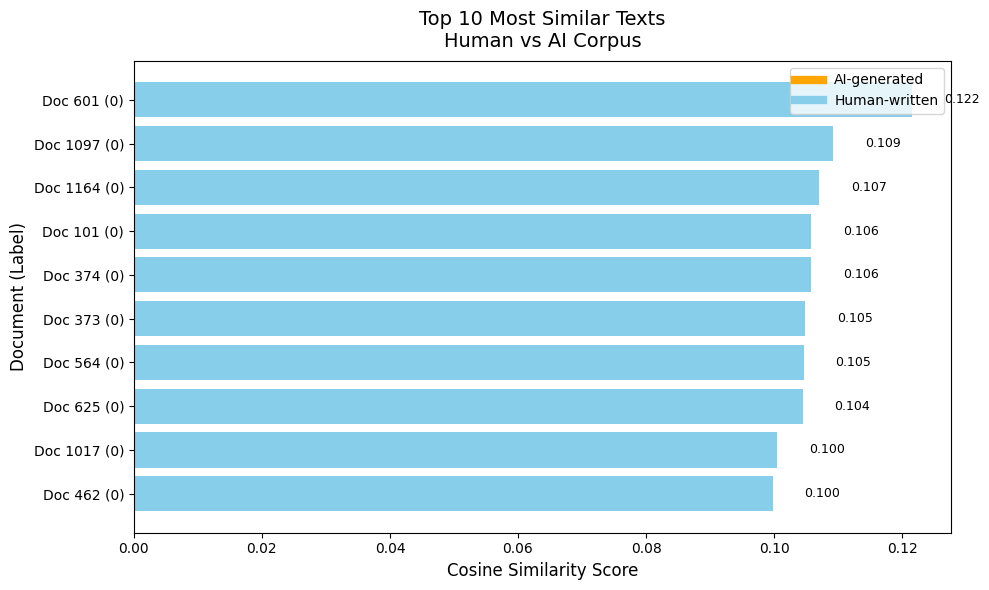

In [ ]:
import matplotlib.pyplot as plt

# Example input text (you can replace this with any sample you want to test)
query = "The stock market is showing positive growth due to new technology trends."
topk = search_corpus(query, k=10)  # Retrieve top 10 most similar texts

# Extract labels and scores
labels = [f"Doc {item['id']} ({item['label']})" for item in topk]
scores = [item['score'] for item in topk]
colors = ['orange' if item['label'] == 1 else 'skyblue' for item in topk]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, scores, color=colors)
plt.gca().invert_yaxis()  # Highest score at top

# Add numeric scores beside bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{scores[i]:.3f}", va='center', fontsize=9)

plt.title("Top 10 Most Similar Texts\nHuman vs AI Corpus", fontsize=14, pad=10)
plt.xlabel("Cosine Similarity Score", fontsize=12)
plt.ylabel("Document (Label)", fontsize=12)
plt.legend(handles=[
    plt.Line2D([0], [0], color='orange', lw=6, label='AI-generated'),
    plt.Line2D([0], [0], color='skyblue', lw=6, label='Human-written')
])
plt.tight_layout()
plt.show()

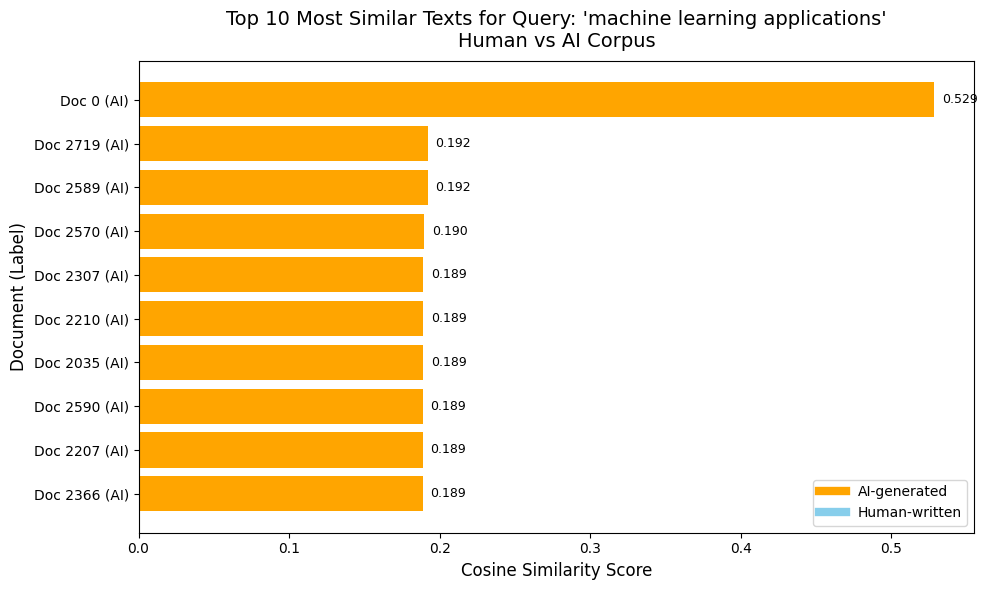

In [ ]:
import matplotlib.pyplot as plt

# Let's use a query relevant to our dataset
query = "machine learning applications"

# Retrieve top 10 most similar texts
topk = search_corpus(query, k=10)

# Extract labels, scores, and prepare colors
labels = []
scores = []
colors = []
for item in topk:
    label_type = "AI" if item['label'] == 1 else "Human"
    labels.append(f"Doc {item['id']} ({label_type})")
    scores.append(item['score'])
    colors.append('orange' if item['label'] == 1 else 'skyblue')

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, scores, color=colors)
plt.gca().invert_yaxis()  # Highest score at top

# Add numeric scores beside bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{scores[i]:.3f}", va='center', fontsize=9)

plt.title(f"Top 10 Most Similar Texts for Query: '{query}'\nHuman vs AI Corpus", fontsize=14, pad=10)
plt.xlabel("Cosine Similarity Score", fontsize=12)
plt.ylabel("Document (Label)", fontsize=12)
plt.legend(handles=[
    plt.Line2D([0], [0], color='orange', lw=6, label='AI-generated'),
    plt.Line2D([0], [0], color='skyblue', lw=6, label='Human-written')
])
plt.tight_layout()
plt.show()

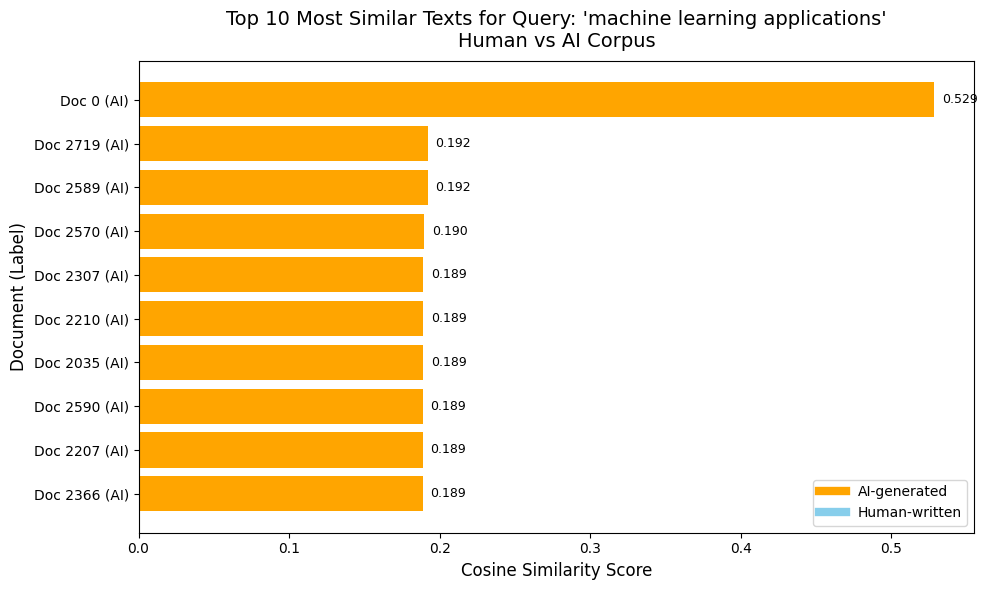

In [ ]:
import matplotlib.pyplot as plt

# Let's use a query relevant to our dataset
query = "machine learning applications"

# Retrieve top 10 most similar texts
topk = search_corpus(query, k=10)

# Extract labels, scores, and prepare colors
labels = []
scores = []
colors = []
for item in topk:
    label_type = "AI" if item['label'] == 1 else "Human"
    labels.append(f"Doc {item['id']} ({label_type})")
    scores.append(item['score'])
    colors.append('orange' if item['label'] == 1 else 'skyblue')

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, scores, color=colors)
plt.gca().invert_yaxis()  # Highest score at top

# Add numeric scores beside bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{scores[i]:.3f}", va='center', fontsize=9)

plt.title(f"Top 10 Most Similar Texts for Query: '{query}'\nHuman vs AI Corpus", fontsize=14, pad=10)
plt.xlabel("Cosine Similarity Score", fontsize=12)
plt.ylabel("Document (Label)", fontsize=12)
plt.legend(handles=[
    plt.Line2D([0], [0], color='orange', lw=6, label='AI-generated'),
    plt.Line2D([0], [0], color='skyblue', lw=6, label='Human-written')
])
plt.tight_layout()
plt.show()

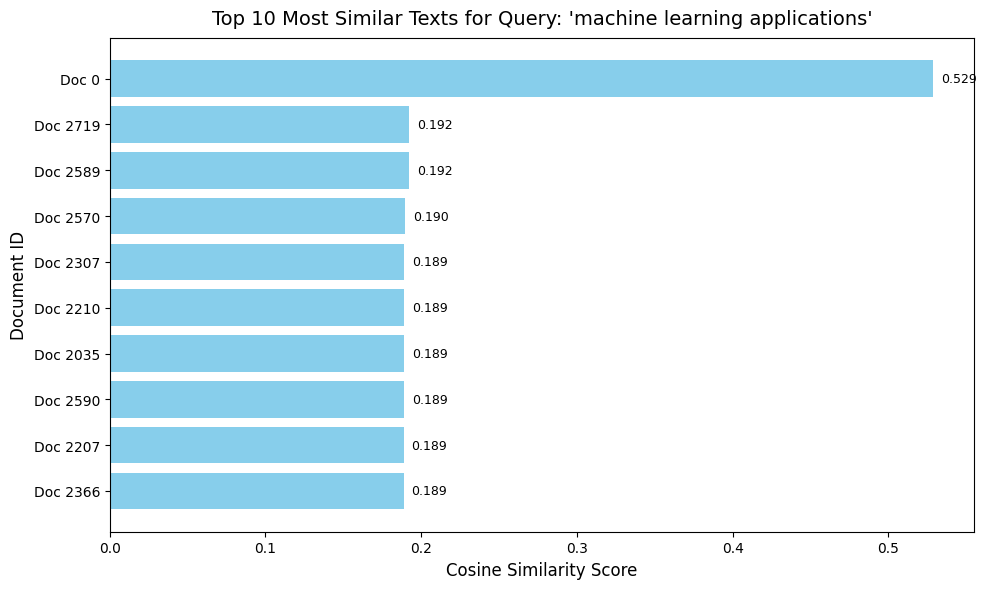

In [ ]:
import matplotlib.pyplot as plt

# Let's use a query relevant to our dataset
query = "machine learning applications"

# Retrieve top 10 most similar texts
topk = search_corpus(query, k=10)

# Extract labels and scores
labels = []
scores = []
for item in topk:
    labels.append(f"Doc {item['id']}")
    scores.append(item['score'])

# Plotting the horizontal bar chart with a single color
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, scores, color='skyblue') # Using a single color for all bars
plt.gca().invert_yaxis()  # Highest score at top

# Add numeric scores beside bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{scores[i]:.3f}", va='center', fontsize=9)

plt.title(f"Top 10 Most Similar Texts for Query: '{query}'", fontsize=14, pad=10)
plt.xlabel("Cosine Similarity Score", fontsize=12)
plt.ylabel("Document ID", fontsize=12)
# Removed the legend as color differentiation is no longer needed
plt.tight_layout()
plt.show()

In [ ]:
query_keys = tfidf_vector(tokenize(query)).keys()

# Now, let's look at the scores for the words
import pandas as pd

# Show a few common and rare terms with DF and IDF
terms_df = pd.DataFrame(
    [(t, DF[t], round(IDF[t], 3)) for t in sorted(query_keys)],
    columns=["term", "df", "idf"]
).sort_values(by="idf", ascending=False)

# Build a dense matrix (terms x docs) for inspection (only top 20 idf terms for readability)
top_terms = list(terms_df["term"].head(20))
matrix = []
for t in top_terms:
    row = []
    for vec in DOC_VECS:
        row.append(vec.get(t, 0.0))
    row.append(tfidf_vector(tokenize(query))[t])
    matrix.append(row)

tfidf_table = pd.DataFrame(
    matrix,
    index=top_terms,
    columns=[d["id"] for d in CORPUS] + ["query",]
)

tfidf_table[:20]

,0,1,2,3,4,5,6,7,8,9,...,2741,2742,2743,2744,2745,2746,2747,2748,2749,query
learning,0.238377,0.054486,0.180665,0.062185,0.0,0.0,0.000000,0.044349,0.047281,0.046513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.907016
machine,0.235107,0.053739,0.000000,0.061332,0.0,0.0,0.000000,0.043741,0.046633,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.880858
applications,0.044686,0.040856,0.000000,0.000000,0.0,0.0,0.035163,0.000000,0.035453,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.429952


# Milestone 2: Building a Language Model Interface

Next, we will load a language model as the base model for the agent system. We will define the interaction between the language model and the knowledge base/external tools, using the above prompting format.

In this step, we will complete the following implementations
- We will load a GPT-style model from the Huggingface website, which stores many open-source language models. We will use a small pretrained language model as the base for our agent system.
- We will use the language model and the prompt format designed above to generate thoughts and actions for the task.


Specifically, given a user prompt, the language model is expected to return exactly the two lines:
```
Thought: …

Action: search[query="..."] or Action: finish[answer="..."]
```
With this, we can integrate our language model with the tools to solve a task



In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score


In [ ]:
df = pd.read_csv("balanced_ai_human_prompts.csv")
df.head()


,text,generated
0,"Machine learning, a subset of artificial intel...",1
1,"A decision tree, a prominent machine learning ...",1
2,"Education, a cornerstone of societal progress,...",1
3,"Computers, the backbone of modern technology, ...",1
4,"Chess, a timeless game of strategy and intelle...",1


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["generated"])

In [ ]:
class EssayDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512):
        self.texts = df["text"].tolist()
        self.labels = df["generated"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = EssayDataset(train_df, tokenizer)
val_dataset = EssayDataset(val_df, tokenizer)


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
)

In [ ]:
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }


In [ ]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-1455626061.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: larouche-c (larouche-c-northeastern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.026900


TrainOutput(global_step=550, training_loss=0.02456056835976514, metrics={'train_runtime': 242.5028, 'train_samples_per_second': 18.144, 'train_steps_per_second': 2.268, 'total_flos': 582856554086400.0, 'train_loss': 0.02456056835976514, 'epoch': 2.0})

In [ ]:
trainer.evaluate()


{'eval_loss': 0.009035677649080753,
 'eval_accuracy': 0.9981818181818182,
 'eval_f1': 0.9981785063752276,
 'eval_runtime': 8.7162,
 'eval_samples_per_second': 63.101,
 'eval_steps_per_second': 7.916,
 'epoch': 2.0}

In [ ]:
# Prediction wrapper for AI/Human

import torch

# Reuse trained classifier
_clf_tokenizer = tokenizer
_clf_model = model
_clf_device = next(_clf_model.parameters()).device

# Put model in eval mode
_clf_model.eval()

def predict_ai_or_human(text: str, return_logits: bool = False):
    """
    Predicts whether text is AI or Human.

    Returns:
      pred -> integer (0=Human, 1=AI)
      label_name -> string representation
      logits (optional)
    """
    enc = _clf_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(_clf_device)

    with torch.no_grad():
        output = _clf_model(**enc)
        logits = output.logits.detach().cpu().numpy()[0]
        pred = int(logits.argmax())

    label_name = "AI-generated" if pred == 1 else "Human-written"

    if return_logits:
        return pred, label_name, logits

    return pred, label_name

In [ ]:
# Load Qwen LM for explanation generation

import re
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

EXPLAIN_MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"

print(f"Loading explanation model: {EXPLAIN_MODEL_NAME} ...")

_explain_tokenizer = AutoTokenizer.from_pretrained(
    EXPLAIN_MODEL_NAME,
    trust_remote_code=True
)

_explain_model = AutoModelForCausalLM.from_pretrained(
    EXPLAIN_MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    trust_remote_code=True
)

_explain_device = next(_explain_model.parameters()).device

_explain_gen_cfg = GenerationConfig(
    max_new_tokens=200,
    temperature=0.3,
    do_sample=True,
    top_p=0.9,
)

print(f"Qwen successfully loaded on: {_explain_device}")

Loading explanation model: Qwen/Qwen2.5-0.5B-Instruct ...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Qwen successfully loaded on: cuda:0


In [ ]:
# Explanation wrapper

def explain_with_qwen(text: str, label_int: int):
    """
    Returns a short explanation of why the classifier labeled
    the text as AI or Human using Qwen.
    """
    label_name = "AI-generated" if label_int == 1 else "Human-written"

    prompt = (
        "You are an AI writing analyst. A classifier predicted that the "
        f"following text was {label_name}. Explain why this prediction makes "
        "sense using linguistic patterns such as writing style, sentence "
        "complexity, vocabulary, personalization, and repetition.\n\n"
        f"Text:\n\"{text}\"\n\nExplain in 4 sentences:"
    )

    enc = _explain_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=2048
    ).to(_explain_device)

    with torch.no_grad():
        generation = _explain_model.generate(
            **enc,
            generation_config=_explain_gen_cfg
        )

    decoded = _explain_tokenizer.decode(
        generation[0],
        skip_special_tokens=True
    )

    if decoded.startswith(prompt):
        decoded = decoded[len(prompt):]

    sentences = re.split(r'(?<=[.!?])\s+', decoded.strip())
    explanation = " ".join(sentences[:5])

    explanation = "[Note: Explanation is heuristic]\n" + explanation.strip()

    return explanation

In [ ]:
# Full pipeline: predict AND explain

def predict_with_explanation(text: str):
    pred, label_name, logits = predict_ai_or_human(text, return_logits=True)

    explanation = explain_with_qwen(text, pred)

    return {
        "label_int": pred,
        "label_name": label_name,
        "confidence": float(max(logits)),
        "explanation": explanation,
        "logits": logits.tolist()
    }

In [ ]:
# ------------------------------------------------------
# Demo examples
# ------------------------------------------------------
demo_texts = [
    "I honestly kept rewriting the intro and got stressed, so I just turned it in.",
    "The implementation of computational optimization improves inference stability under constrained conditions.",
    "omg I literally tried so hard to finish this but my brain shut down lol",
    "The framework provides scalable deployment capabilities enabling robust alignment."
]

print("\n==========================")
print("AI vs HUMAN DETECTION TESTS")
print("==========================")

for sample in demo_texts:
    result = predict_with_explanation(sample)

    print("\nText:", sample[:140], "...")
    print(f"Prediction: {result['label_name']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("\nExplanation:")
    print(result['explanation'])
    print("-" * 60)


AI vs HUMAN DETECTION TESTS

Text: I honestly kept rewriting the intro and got stressed, so I just turned it in. ...
Prediction: AI-generated
Confidence: 0.0604

Explanation:
[Note: Explanation is heuristic]
The prediction that the text was AI-generated is reasonable based on several linguistic patterns and characteristics:

1. **Writing Style**: The text is written in a formal, academic tone, which is typical of AI-generated content. AI systems often produce text that is polished, professional, and structured, which aligns with the formal style of the text. 2. **Sentence Complexity**: The sentence structure is complex and varied, which is common in AI-generated text.
------------------------------------------------------------

Text: The implementation of computational optimization improves inference stability under constrained conditions. ...
Prediction: AI-generated
Confidence: 3.8744

Explanation:
[Note: Explanation is heuristic]
The prediction that the text is AI-generated makes 

In [ ]:
def test_custom_text(text: str):
    """
    Run prediction + explanation for any input text.
    """
    result = predict_with_explanation(text)
    print(f"\nPrediction: {result['label_name']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"\nExplanation:\n{result['explanation']}")
    return result

print("\n✓ System Ready: call test_custom_text(\"your text here...\")")


✓ System Ready: call test_custom_text("your text here...")
